In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # removes the warning messages from tensorflow

In [2]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import pywt
import funcs
import plot_learning_callback
import f1_metric

In [3]:
# use gpu

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')


In [5]:
#add a dummy dimension
trainReadings = np.expand_dims(trainReadings, axis=2)
validateReadings = np.expand_dims(validateReadings, axis=2)
testReadings = np.expand_dims(testReadings, axis=2)

In [6]:
trainReadings.shape

(10977, 1000, 1)

In [7]:
sigmoidLoss = tf.keras.losses.BinaryCrossentropy() # one output unit
softmaxLoss = tf.keras.losses.CategoricalCrossentropy() # two output units

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics, callbacks

In [9]:
inputShape = (1000, 1)
kernelSize = 20 #how to determine this

In [10]:
convInputLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize, input_shape=inputShape, data_format="channels_last")
convLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize)
batchNormLayer = layers.BatchNormalization(axis=1)
reLULayer = layers.ReLU()
maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize * 2, strides=None) # should the size of the pooling layer be the same as the kernel size

In [11]:
metrics=['accuracy', 
         tf.keras.metrics.FalsePositives(name='false_positives'), 
         tf.keras.metrics.Precision(name='precision'), 
         tf.keras.metrics.Recall(name='recall'), 
         f1_metric.f1]

In [12]:
# create a checkpoint for the best val

current_directory = os.getcwd()
best_file_name = 'weights-improvement-{epoch:02d}-val_f1-{val_f1:.2f}.hdf5' 

# model weights are stored in hdf5 file

best_file_path = os.path.join(current_directory, 'no_cwt_ckpt', best_file_name)

checkpoint = callbacks.ModelCheckpoint(filepath=best_file_path, 
                                       save_weights_only=True, 
                                       monitor='val_f1',
                                       mode='max', #save when the f1 score is the highest
                                       save_best_only=True, 
                                      )

In [13]:
# adding dropout layer to prevent overfitting

tf.random.set_seed(42)

inputDroppedPercent = 20 # during training, 20 percent of the inputs (to the dropout layer) are randomly dropped
dropoutLayer = layers.Dropout(inputDroppedPercent / 100)
sectionRepeat = 3

In [14]:
model = Sequential()

for i in range(sectionRepeat):
    model.add(convLayer)
    model.add(batchNormLayer)
    model.add(dropoutLayer) # change to architecture
    model.add(reLULayer)
    model.add(maxPoolLayer)

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

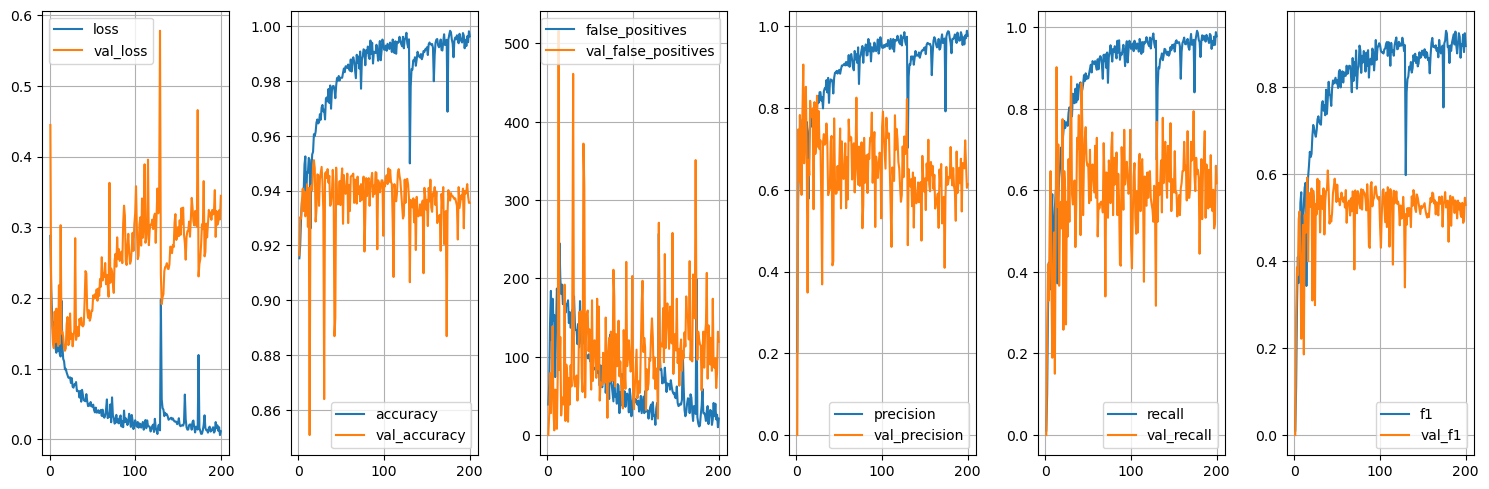

344/344 [==============================] - 9s 25ms/step - loss: 0.0115 - accuracy: 0.9963 - false_positives: 21.0000 - precision: 0.9767 - recall: 0.9778 - f1: 0.8941 - val_loss: 0.3444 - val_accuracy: 0.9355 - val_false_positives: 119.0000 - val_precision: 0.6136 - val_recall: 0.6176 - val_f1: 0.5289


In [16]:
history = model.fit(
    trainReadings, trainDiagnostic, 
    epochs=200, 
    validation_data=(validateReadings, validateDiagnostic), 
    callbacks=[plot_learning_callback.PlotLearning(), checkpoint]
)

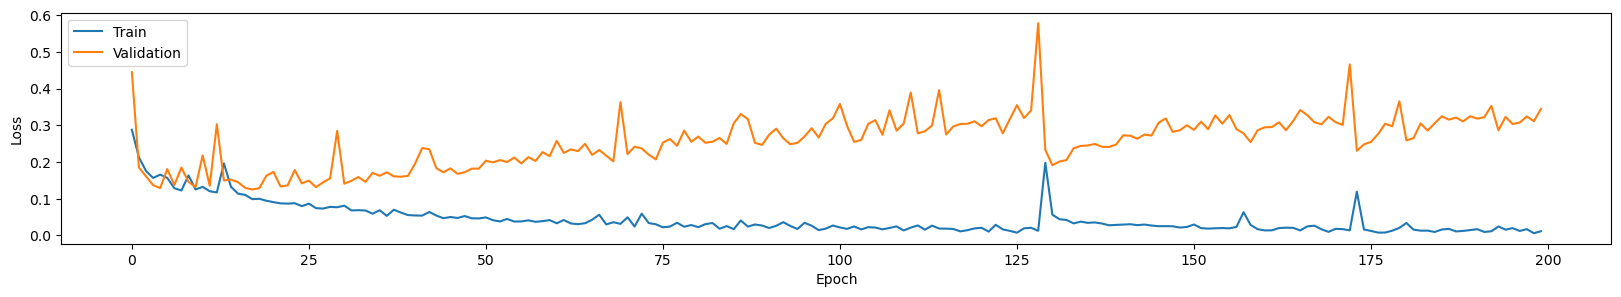

In [17]:
funcs.graph_losses(history, "Loss")

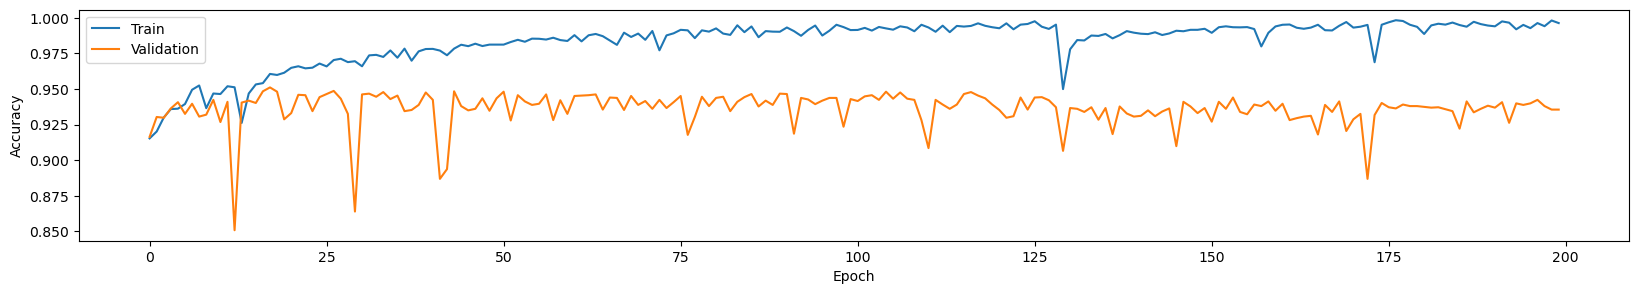

In [18]:
funcs.graph_losses(history, "Accuracy")

In [19]:
best_model = tf.keras.models.clone_model(model)

best_saved = ''
checkpoints = os.listdir(os.path.join(current_directory, 'no_cwt_ckpt'))
max_epoch = 0
for i in checkpoints:
    current_split = i.split("-")
    if int(current_split[2]) > max_epoch:
        best_saved = os.path.join('no_cwt_ckpt', i)
        max_epoch = int(current_split[2])
        
print("Best Model filepath:", best_saved)

best_model.load_weights(best_saved)

Best Model filepath: no_cwt_ckpt/weights-improvement-39-val_f1-0.61.hdf5


In [21]:
best_model.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

In [26]:
best_accuracy_metrics = best_model.evaluate(testReadings, testDiagnostic)
best_accuracy_metrics

115/115 [==============================] - 0s 4ms/step - loss: 0.1752 - accuracy: 0.9355 - false_positives: 150.0000 - precision: 0.5957 - recall: 0.7199 - f1: 0.5634 


[0.17515406012535095,
 0.9355190992355347,
 150.0,
 0.5956873297691345,
 0.7198697328567505,
 0.563357949256897]

In [38]:
def get_f1(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

In [28]:
accuracy = best_accuracy_metrics[1]
precision = best_accuracy_metrics[3]
recall = best_accuracy_metrics[4]
f1 = get_f1(precision, recall)
print("Metrics for the non-CWT model when ran on test set:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Metrics for the non-CWT model when ran on test set:

Accuracy: 0.9355190992355347
Precision: 0.5956873297691345
Recall: 0.7198697328567505
F1 Score: 0.6519174137397398


In [40]:
best_model_pred = np.round(best_model.predict(testReadings))
afib_correct = 0
afib_total = 0
sinus_correct = 0
sinus_total = 0
for i in range(len(testDiagnostic)):
    if testDiagnostic[i] == 1:
        afib_total += 1
        if testDiagnostic[i] == best_model_pred[i]:
            afib_correct += 1
    else:
        sinus_total += 1
        if testDiagnostic[i] == best_model_pred[i]:
            sinus_correct += 1

print("Sinus Class Accuracy:", sinus_correct / sinus_total)
print("Afib Class Accuracy:", afib_correct / afib_total)

115/115 [==============================] - 0s 3ms/step
Sinus Class Accuracy: 0.9552639427378466
Afib Class Accuracy: 0.7198697068403909


In [42]:
tp = 0
fp = 0
fn = 0

for i in range(len(testDiagnostic)):
    if testDiagnostic[i] == 1 and best_model_pred[i] == 1:
        tp += 1
    elif testDiagnostic[i] == 0 and best_model_pred[i] == 1:
        fp += 1
    elif testDiagnostic[i] == 1 and best_model_pred[i] == 0:
        fn += 1
print(tp / (tp + fp))
print(tp / (tp + fn))


0.5956873315363881
0.7198697068403909


In [46]:
best_model.get_metrics_result()


AttributeError: 'Sequential' object has no attribute 'get_metrics_result'